# Ator-crítico TD(0) (episódico)

#### Prof. Armando Alves Neto - Introdução ao Aprendizado por Reforço - PPGEE/UFMG

<img src="cart_pole.gif" width="400">

Objetivo: usar o método ator-crítico TD(0) (episódico) para estimar uma política $\pi(a|s, \boldsymbol{\theta})$ que controle um pêndulo invertido.

## Características do pêndulo:

### Espaço de observações

| Número | Observação | Min | Max |
| :-: | :- | :-: | :-: |
| 0	| Posição do carrinho | -4.8 | 4.8|
| 1	| Velocidade do carrinho | $-\infty$ | $\infty$|
| 2	| Ângulo do pêndulo | -0.418 rad (-24°)	| 0.418 rad (24°)|
| 3	| Velocidade angular do pêndulo	| $-\infty$ | $\infty$ |

### Espaço de ações
| Número | Ação |
| :-: | :- |
| 0	| Carrinho para a esquerda |
| 1	| Carrinho para a direita |

### Função de reforço

- Devolve +1 para cada passo antes do pêndulo cair.
- Episódio termina quando o ângulo do pêndulo excede ±12°, ou quando a posição do carrinho é maior que ±2.4.
- Máximo de 200 passos.

Importando as bibliotecas.

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,5)
from IPython.display import clear_output
from collections import deque
import seaborn as sns
sns.set()

Cria uma classe (```RunningAverage()```) apenas para calcular a média móvel do sinal de reforço.

In [2]:
class RunningAverage(object):
    def __init__(self, N):
        self.buffer = deque(maxlen=N)

    def push(self, val):  
        self.buffer.append(val)

    def get(self):
        return np.mean(self.buffer)

Essa rede representa uma função diferenciável $\pi(a|s, \boldsymbol{\theta})$ que fornece a probabilidade de cada ação $a$ ser escolhida, dado um estado $s$. A arquitetura da Rede Neural Artificial (Perceptron) tem ```state_size``` entradas, ```action_size``` saídas e uma camada escondida de tamanho ```hidden_size = 64```.

In [3]:
class Policy(nn.Module):
    ##########################################
    def __init__(self, state_size, action_size, hidden_size=128):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    ##########################################
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    ##########################################
    def act(self, state, device):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # saida da rede é a probabilidade de cada ação para o estado
        probs = self.forward(state).to(device)
        # escolhe a ação aleatoria segundo a probabilidade categorical
        model = Categorical(probs)
        action = model.sample()
        # retorna ação e log da probabilidade dela
        return action.item(), model.log_prob(action)

Essa rede representa uma função diferenciável $\hat{v}(s, \boldsymbol{w})$ que fornece o valor de um dado $s$. A arquitetura da Rede Neural Artificial (Perceptron) tem ```state_size``` entradas, uma saída e uma camada escondida de tamanho ```hidden_size = 64```.

In [4]:
class StateValue(nn.Module):
    ##########################################
    def __init__(self, state_size, hidden_size=128):
        super(StateValue, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    ##########################################
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
    ##########################################
    def val(self, state, device):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        return self(state)

Criando a classe do algortimo do Ator-crítico.

In [5]:
class ActorCritic(object):
    def __init__(self, parameters):
        
        self.parameters = parameters

        # numero de episodios
        self.episode = 0
        self.max_iter = parameters['max_iter']
        
        # parametros de aprendizado
        self.gamma = parameters['gamma']
        self.alpha = parameters['alpha']
        self.beta  = parameters['beta']
        self.device = parameters['device']

        # cria ambiente
        self.env = gym.make('CartPole-v0')

        # cria as funções parametricas da política e do valor
        self.stateval_network = StateValue(self.env.observation_space.shape[0]).to(self.device)
        self.policy_network = Policy(self.env.observation_space.shape[0], self.env.action_space.n).to(self.device)

        # otimizadores das redes neurais
        self.stateval_optimizer = optim.Adam(self.stateval_network.parameters(), lr=self.alpha)
        self.policy_optimizer   = optim.Adam(self.policy_network.parameters(), lr=self.beta)

Executando um episódio.

In [6]:
class ActorCritic(ActorCritic):
    ##########################################
    def runEpisode(self, print_every=50):
        
        # novo episodio
        self.episode += 1
        
        rewards = []
        I = 1.0
        
        # reseta o ambiente
        S = self.env.reset()

        for _ in range(self.max_iter):

            # Amostra uma ação da politica corrente
            A, lp = self.policy_network.act(S, self.device)

            # passo de interacao com o ambiente
            Sl, R, done, _ = self.env.step(A)
            rewards.append(R)

            # valor do estado corrente e futuro
            vSw  = self.stateval_network.val(S, self.device)
            vSlw = self.stateval_network.val(Sl, self.device)

            #se estado terminal, próximo valor é zero
            if done: vSlw *= 0.0
            
            # Função de perda do valor
            val_loss = F.l1_loss(R + self.gamma*vSlw, vSw)

            # Calcula função de perda da política
            policy_loss = -lp * (R + self.gamma * vSlw.item() - vSw.item())
            policy_loss *= I
            
            # Backpropagate política
            self.policy_optimizer.zero_grad()
            policy_loss.backward(retain_graph=True)
            self.policy_optimizer.step()
            
            # Backpropagate valor
            self.stateval_optimizer.zero_grad()
            val_loss.backward()
            self.stateval_optimizer.step()           

            if done: break
                
            # renderiza o ambiente
            if self.episode % print_every == 0:
                self.env.render()

            # proximo estado
            I *= self.gamma
            S = Sl
            
        return np.sum(np.array(rewards))

Programa principal:
- episodes: número de episódios
- max_iter: máximo de iterações até o fim do episódio
- gamma: fator de desconto
- alpha: $\alpha$
- beta: $\beta$
- solved: valor de retorno máximo esperado

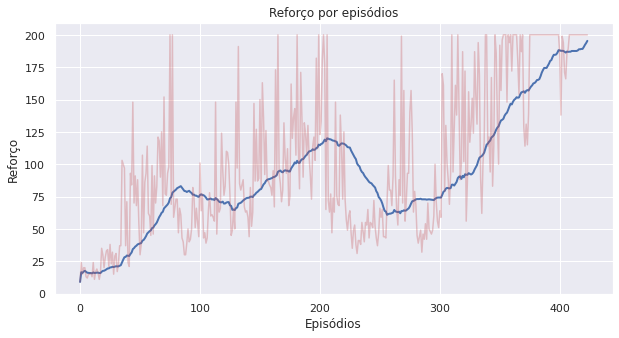

In [7]:
if __name__ == '__main__':

    plt.ion()

    # cria objeto para calculo da média movel do reward
    avg_calc = RunningAverage(50)
    
    # parametros
    parameters = {'episodes'  : 500,
                  'max_iter'  : 200,
                  'gamma'     : 0.99,
                  'alpha'     : 0.002,
                  'beta'      : 0.001,
                  'device'    : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                  'solved'    : 195.0,
                 }
    
    # historico dos reforços
    rewards = []
    avg_rewards = []
    
    ac = ActorCritic(parameters)
    
    while ac.episode <= parameters['episodes']:
        
        # roda um episodio
        total_reward = ac.runEpisode()

        # rewards
        rewards.append(total_reward)
        # reward medio
        avg_calc.push(total_reward)
        avg_rewards.append(avg_calc.get())

        plt.figure(1)
        clear_output(wait=True)
        plt.clf()
        plt.plot(avg_rewards, 'b', linewidth=2)
        plt.plot(rewards, 'r', alpha=0.3)
        plt.title('Reforço por episódios')
        plt.xlabel('Episódios')
        plt.ylabel('Reforço')

        plt.show()
        plt.pause(.1)
        
        # resolvido quando atingir retorno médio máximo
        if avg_rewards[-1] >= parameters['solved']:
            break

    plt.ioff()